# Using the Macrotools Package

## Setting up the Python environment

1. Install [Anaconda](https://www.anaconda.com/download). Anaconda is a Python distribution that comes with a lot of the commonly-used packages in economics. If doing one-off tasks, playing around with data, open up Jupyterlab. You can either work in a notebook (like this) or a terminal.
2. Optional: Install [VSCode](https://code.visualstudio.com/). If doing something more involved or doing tasks that will need to be repeated often, best to write a script. See my jobsday/ folder or even macrotools_testing/ for examples. I recommend using VSCode. The extensions for Jupyter and Claude Code are also useful (if using Claude Code, you need an updated [node.js](https://nodejs.org/en)).

## Installing Macrotools

Install the package using `pip`. You will need to restart your Kernel (Kernel -> Restart Kernel) after running `pip`.

In [11]:
pip install macrotools

Note: you may need to restart the kernel to use updated packages.


You can load the package using <code>import</code>. Here we will use <code>mt</code> as an alias to make typing easier. When calling `macrotools` functions, one must append `macrotools.` or, in this case, `mt.` to the function (see below for examples)

In [2]:
import macrotools as mt

The following packages are also helpful for dealing with time series macro data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

## Pulling Data

<code>macrotools</code> comes with two tools to pull data, <code>pull_data</code> and <code>pull_bls_series</code>. You can retrieve information about any by using `help()`; for example, `help(mt.pull_data)` will provide documentation about the `pull_data` function.

### Pulling Flat Files

<code>pull_data</code> pulls flat files for each data source; for example, it pulls all of the data series for CPI data (for all months) at once.

<code>pull_data</code> has the following arguments:
1. `source` - a <code>str</code> variable that indicates which flat file you want;
2. `email` - a <code>str</code> variable that is an email address; it is required if you are pulling a BLS series.
3. `pivot` - a `Boolean` (`True` or <code>False</code>) argument that determines for BLS series if the output is in long form (which returns all data series) or wide (which returns all data series at the monthly level). <code>pivot</code> is `true` by default.
4. `save_file` - a `str` variable which, if provided, saves the file at `save_file` as a `.pkl` object.
5. `force_refresh` - `Boolean` variable, default `False`. If `True`, bypasses the cache'd file and downloads the data directly from the source.
6. `cache` - `Boolean` variable, default `True`. If `True`, saves the file as .pkl in the cache.

The output of <code>pull_data</code> is a pandas table where the indices are datetime objects and the columns are series. For BLS series, the columns are the series codes from the BLS.

`pull_data` caches the result in a `.macrodata_cache` folder in the user's home directory. Subsequent calls to `pull_data` will load the cached data unless specified otherwise with `force_refresh=True`. `pull_data` will refresh the data if the cached result is older than 7 days.

As of now, <code>pull_data</code> supports pulling the following flat files
* 'ln': Household survey labor force statistics.
* 'ce': Establishment survey statistics.
* 'jt': Job Openings and Labor Turnover Survey
* 'cu': CPI (all Urban Consumers)
* 'pc': PPI Industry Data
* 'wp': PPI Commodity Data
* 'nipa-pce': NIPA PCE data

Here is an example that pulls the household survey flat files and saves them in 'lndata.pkl'. It can be reloaded with `data = pd.read_pickle('lndata.pkl')

In [5]:
lndata = mt.pull_data('ln', save_file='lndata.pkl')

Pulling data from source: ln
Converting File to Pivot Table. Be aware that this will drop footnotes and only keep monthly data. If you want long data, set pivot=False
pull_data execution time: 16.87 seconds


We can now work with `lndata` using `pandas` tools (see [QuantEcon](https://python-programming.quantecon.org/pandas.html) or numerous other online resources for more). For example, this to get the prime-age employment rate (LNS12300060) for months Jan. 2025 forward:

In [7]:
lndata.loc['2025-01':'2025-06']['LNS12300060']

date
2025-01-01    80.7
2025-02-01    80.5
2025-03-01    80.4
2025-04-01    80.7
2025-05-01    80.5
2025-06-01    80.7
Freq: MS, Name: LNS12300060, dtype: float64

When pulling flat files, `macrotools.pull_data` also stores the series ids and names in the attributes of the flat file. For example, `lndata.attrs['series']` for our `lndata` object. Here are the first 5 entries from that object, and how to see, for example, what 'LNS12300060' maps to

In [8]:
print(list(lndata.attrs['series'].items())[:5])
lndata.attrs['series']['LNS12300060']

[('LNS11000000', '(Seas) Civilian Labor Force Level'), ('LNS11000000Q', '(Seas) Civilian Labor Force Level'), ('LNS11000001', '(Seas) Civilian Labor Force Level - Men'), ('LNS11000001Q', '(Seas) Civilian Labor Force Level - Men'), ('LNS11000002', '(Seas) Civilian Labor Force Level - Women')]


'(Seas) Employment-Population Ratio - 25-54 yrs.'

### Pulling Single Series

The `pull_bls_series` function provides an easy way to use the BLS API to pull single or multiple series. In the background it will call `pull_data`, so it will use cached data unless specified otherwise.

* `series_list`: Mandatory argument; can be a single string or a set of strings that are BLS series codes. For example, `'LNS12300061'` and `['LNS12300061', 'LNS12300062']` both valid inputs.
* `date_range`: Optional; an `tuple`, e.g. `('2014', '2018') or ('2014-6', '2018-9')`
* `save_file`: Optional; a `str`, e.g. `'data/employmentrates.pkl'` showing where to save the file.
* `force_refresh`: Optional, a `Boolean`, `False` by default; `True` pulls the flat files again from the BLS.

The output of `pull_bls_series` is a DataFrame where the index is months and the columns are series ID's. For example, this pulls the male and female prime-age employment rates for 2021 to 2025:

In [ ]:
employment_rates = mt.pull_bls_series(['LNS12300061','LNS12300062'], ('2021','2025'))
employment_rates.head()

series_id,LNS12300061,LNS12300062
date,,
2021-01-01,82.6,70.4
2021-02-01,82.6,70.7
2021-03-01,82.6,71.1
2021-04-01,82.8,71.1
2021-05-01,83.0,71.3


## macrotools.tsgraph: Making Time Series Charts

`macrotools.tsgraph` is basically a wrapper around `matplotlib`, passing parameters to `matplotlib` but automatically applying EA styles (fonts, colors, etc). It provides flexible support for single-series, multiple series, and dual-axes plots. It covers most use cases for time series graphs.

`macrotools.tsgraph(xdata, ydata, y2data, format_info, save_file)`

`xdata` - X-data points. Either `array-like` if graphing one series (or all series use the same x-data) or `Dict` (f different series use different x-data)

`ydata` - Y-data points. Either `array-like` if graphing one series or `Dict` if graphing multiple series

`y2data` - Y-data points on the second axis. Either `array-like` if graphing one series or `Dict` if graphing multiple series

`format_info` - An optional `Dict` Contains a list of graph settings.

`save_file` - An optional `str` containing where you want the .png image to be saved. If no `save_file` provided, image will not be saved.

There are many options for `format_info`; use `help(macrotools.tsgraph)` for more information.

It is easiest to demonstrate with an example. Take our `employment_rates` data we pulled earlier that has male and female prime-age employment rates. Let's start with a simple single-series graph for the male employment rates

### Example: Single Series

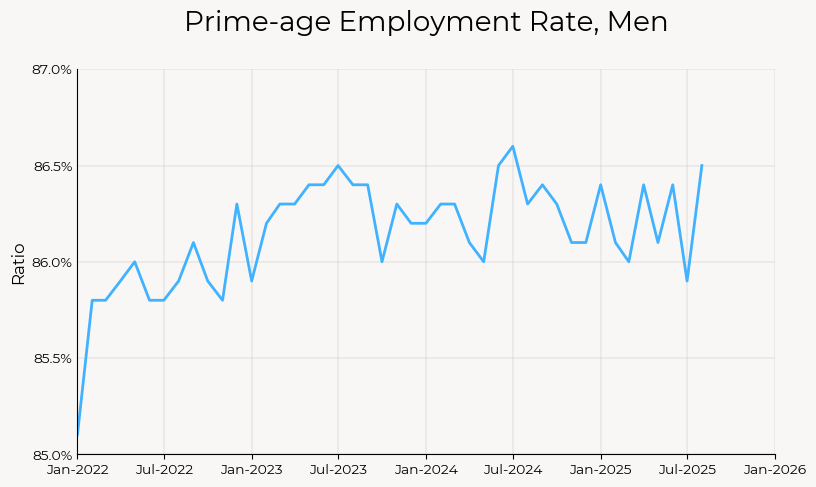

In [10]:
fig1 = mt.tsgraph(
    employment_rates.index,
    employment_rates['LNS12300061']/100,
    format_info = {
        'title': 'Prime-age Employment Rate, Men',
        'xlim': ('2022-01', '2026-01'),
        'xinterval' : 6,
        'ylim': (0.85, 0.87),
        'yticksize': 0.005,
        'ydecimals': 1,
        'ylabel': 'Ratio',
        'ytickformat': 'pctg'
    }
)
plt.show(fig1)

Since our data pull tools create objects where the indices are dates, `employment_rates.index` are the x-data points.

Format_info is a `Dict` object of format `{'setting': 'value'}`. Some settings will be automatically determined (like the height of the title) but others should always be specified, such as the `xlim` and `ylim` attributes.

* `'title': 'Prime-age Employment Rate, Men'`: `title` is a `str` input that contains the title.
* `'xlim': ('2022-01', '2026-01')`: a `tuple` that sets the limits of the x-axis. Note that this way you don't need to subset your data before graphing it.
* `'xinterval' : 6`: an `int` that determines how far apart the x-ticks are. Here, 6 refers to 6 units on the datetime index (which is expressed in monthly frequency)
* `'ylim': (0.85, 0.87)`: If left out, `matplotlib` will attempt to set the y-limits based on the min and max values of `xdata` and `ydata`, without reference to `xlim`. For that reason it is recommended to always set your `ylims`. You can use `.min()` and `.max()` to get a sense of your data limits, e.g. `employment_rates.loc['2022-01':'2024-12']['LNS12300061'].min()` will show the minimum value of LNS12300061 between 2022-1 and 2024-12.
* `'yticksize' : 0.005` : The distance between yticks.
* `'ydecimals' : 1` : Number of decimal points on your yticks.
* `'ylabel' : 'Ratio'` : Y-axis label
* `'ytickformat' : 'pctg'` : Either 'pctg' for percents or 'dec' for plain numbers.

### Example: Two Series, One Axis

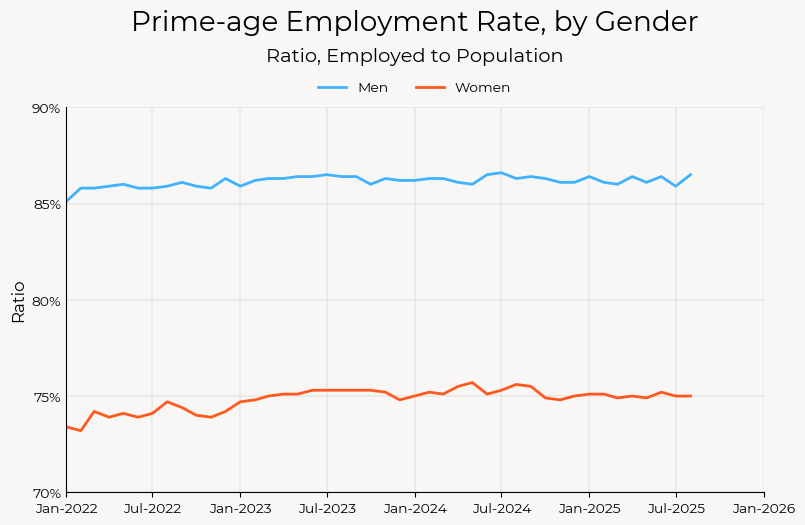

In [11]:
fig2 = mt.tsgraph(
    employment_rates.index,
    {'Men': employment_rates['LNS12300061']/100, 'Women': employment_rates['LNS12300062']/100},
    format_info = {
        'title': 'Prime-age Employment Rate, by Gender',
        'subtitle': 'Ratio, Employed to Population',
        'xlim': (pd.to_datetime('2022-01'), pd.to_datetime('2026-01')),
        'xinterval' : 6,
        'ylim': (0.7, 0.9),
        'yticksize': 0.05,
        'ydecimals': 0,
        'ylabel': 'Ratio',
        'ytickformat': 'pctg',
        'legend': 'on',
        'colors': ['C0','C1']
    }
)
plt.show(fig2)

Note how `ydata` is now a tuple with the format `{'Label1' : series1, 'Label2' : series2}`. The labels will be the same labels used in the legend.

A note on colors: by default, `tsgraph` will cycle through the EA brand colors (blue, orange, green, purple, yellow, magenta and violet). These can be called in order with `'C0'`, `'C1'`, and so on. They can also be called by name with `mt.eacolors['eablue']`, `mt.eacolors['eaorange']` and so on.

### Example: Dual Axes Chart

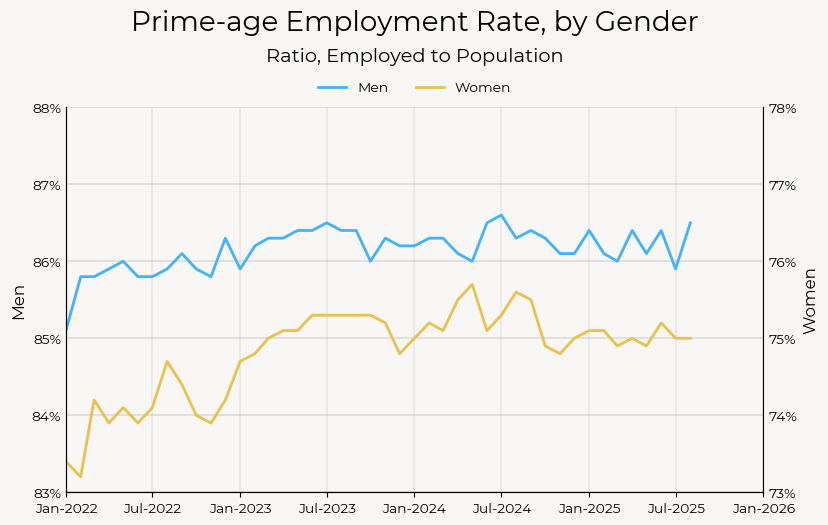

In [15]:
fig3 = mt.tsgraph(
    xdata = {
        'Men': employment_rates.index,
        'Women': employment_rates.index
    },
    ydata = {'Men': employment_rates['LNS12300061']/100},
    y2data = {'Women': employment_rates['LNS12300062']/100},
    format_info = {
        'title': 'Prime-age Employment Rate, by Gender',
        'subtitle': 'Ratio, Employed to Population',
        'xlim': ('2022-01', '2026-1'),
        'xinterval' : 6,
        'ylim': (0.83, 0.88), 'yticksize': 0.01, 'ylabel': 'Men', 'ydecimals': 0, 'ytickformat': 'pctg',
        'y2lim': (0.73, 0.78), 'y2ticksize': 0.01, 'y2label': 'Women', 'y2decimals': 0, 'y2tickformat': 'pctg',
        'colors': 'C0', 'colors2': 'C4',
        'legend': 'on'
    }
)
plt.show(fig3)

Note the differences in the inputs from before:

* `xdata` `{'Men': employment_rates.index,'Women': employment_rates.index}`: Strictly speaking this wasn't necessary; `xdata: employment_rates.index` would have sufficed. But if the two time series were using different x data points, this is how you would do it.
* `'y2lim': (0.73, 0.78), 'y2ticksize': 0.01, 'y2label': 'Women', 'y2decimals': 0, 'y2tickformat': 'pctg'`: Another set of entries for `format_info` that govern the look of the second y-axis.

You can access the graph afterwards in a few ways. You can show the graph in the notebook or jupyterlab terminal with `plot.show()` as above, and use `shift` + `right-click` to save the image. Alternatively, you can use the `save_file` option in `mt.tsgraph` (e.g. `save_file = output/graph.png` to save the graph as a png file.

## Time Series Functions

`macrotools` comes with certain often-used functions that can make working with time-series macro data more convenient.

### macrotools.cagr - Calculate Compounded Annual Growth Rates

`macrotools.cagr` calculates compounded annual rates of change. It allows for flexible moving averages and number of lags.

The syntax is `macrotools.cagr(data, lag, ma)`

`data` : `DataFrame` or `pandas.Series`
The data you want to take CAGR rates of

`lag` : Optional `int`; default value = 1
How many lags to take. For example, lag=4 calculates the annualized growth rate over a 4 periods.

`ma` : Optional `int`; default value = 1
Takes moving averages before calculating CAGRs. For example, ma = 3 takes a 3-period moving average (lagged) before calculating growth rates.

Returns: a `DataFrame` or `pandas.Series`, depending on the input at `data`

In [25]:
employment_rates_growth_rates = mt.cagr(employment_rates, lag=6, ma=3) # Takes the annualized 6-month growth rate of the 3-month moving average of the variables in employment_rates
print(employment_rates_growth_rates.tail())

series_id   LNS12300061  LNS12300062
date                                
2025-04-01    -0.003857    -0.008830
2025-05-01    -0.002317    -0.003549
2025-06-01     0.003097     0.003563
2025-07-01    -0.001546     0.001779
2025-08-01     0.001547     0.000000


### macrotools.rebase - Reindex Series

`macrotools.rebase(data, baseperiod, basevalue)` rebases time series (this is like "FRED's Index (rescale to 100 for chosen date)")

`data` : `DataFrame` or `pandas.Series`
The data you want to rebase

`baseperiod` : either a string (e.g. '2020-1') or a tuple (e.g. ('2020-1', '2020-12'). If a single value, will rebase to that date. If a tuple, will rebase to the average over that range.

`basevalue`: Optional, default 100: Choose what level to rebase to.

Returns: a `DataFrame` or `pandas.Series`, depending on the input at `data`

In [18]:
employment_rates_rebased = mt.rebase(employment_rates, baseperiod=('2023-1','2023-12'))
employment_rates_rebased.head()

series_id,LNS12300061,LNS12300062
date,,
2021-01-01,95.740365,93.741678
2021-02-01,95.740365,94.141145
2021-03-01,95.740365,94.673768
2021-04-01,95.972182,94.673768
2021-05-01,96.203999,94.940080
